In [1]:
import torch
from torch import nn 
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import time
import math
import seaborn as sns
import numpy as np

In [2]:
class NN(nn.Module):
    def __init__(self,):
        super(NN, self).__init__()
        #Linear layers
        self.mod = nn.Sequential(
            nn.Linear(2, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            #nn.Linear(20, 20),
            #torch.nn.Tanh(),
            #nn.Linear(20, 20),
            #torch.nn.Tanh(),
            #nn.Linear(20, 20),
            #torch.nn.Tanh(),
            nn.Linear(20, 1)
        )
        
    def forward(self, inpu):
        out = self.mod(inpu)
        return out

In [3]:
class Model:
    def __init__(self):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(self.device)
        self.model = NN().to(self.device)
        
        #Max iteration
        self.max_iter = 1000
        
        #Criterion for loss 
        self.criterion = nn.MSELoss()
        
        #Optimizer
        self.optimizer = optim.Adam(self.model.parameters())
        
        self.lbfgs = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps
        )
        
        #Initialization for training
        self.x_step = 0.1
        self.t_step = 0.1
        x = torch.arange(-1, 1+self.x_step, self.x_step) #create grid for x-axis
        t = torch.arange(0, 1 + self.t_step, self.t_step) #create grid for t-axis
        
        #Create grid for solution
        self.grid = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T.to(self.device) # Create grid of 2D points
        self.grid.requires_grad = True
        
        #Training data
        bound_1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T # Points for first boundary condition 
        bound_2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T #Points for second boundary condition
        initial = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T # Points for initial condition for x at t=0
        
        self.train_points = torch.cat([bound_1, bound_2, initial]).to(self.device) # Training points as a grid
        u_b1 = torch.zeros(len(bound_1))
        u_b2 = torch.zeros(len(bound_2))
        u_initial = -torch.sin(math.pi * initial[:, 0])# use initial condition from paper (Dirichlet boundary conditions)
        self.y_train = torch.cat([u_b1, u_b2, u_initial])
        self.y_train = self.y_train.unsqueeze(1).to(self.device)
        """
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True
        """
        self.iter = 1


    
    def loss(self):
        self.lbfgs.zero_grad()
        
        y = self.model(self.train_points)
        loss = self.criterion(y, self.y_train) #Compute first part of loss
        u = self.model(self.grid)
        
        #Compute gradients of grid with respect to u and t
        du_dX = torch.autograd.grad(inputs=self.grid, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dx2 = torch.autograd.grad(inputs=self.grid, outputs=du_dX, grad_outputs=torch.ones_like(du_dX), retain_graph=True, create_graph=True)[0][:, 0]
        
        loss += self.criterion(du_dt + u.squeeze() * du_dx, 0.01/math.pi *du_dx2) #Second part of loss, using f(t,x) as in paper
        
        loss.backward()
        #Print loss every 100 iteration
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss

    def train(self):
        for i in range(self.max_iter):
            self.optimizer.step(self.loss)
        #self.lbfgs.step(self.loss)
        
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(self.device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(self.device)

        self.model.eval()
        u = self.model(torch.cat([x, t], dim=1))
        u = u.detach().cpu().numpy()
        return u


In [4]:
model = Model()
model.train()

cuda:0


C:\Users\99\AppData\Roaming\Python\Python39\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.150618776679039
200 0.09054803848266602
300 0.07268644869327545
400 0.04905029386281967
500 0.027801912277936935
600 0.022439181804656982
700 0.017794817686080933
800 0.01612050086259842
900 0.01477137953042984
1000 0.01453455165028572


In [5]:
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
grid = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
grid = grid.to(model.grid.device)

In [6]:
mod = model.model
mod.eval()
with torch.no_grad():
    y_pred = mod(grid).reshape(len(x), len(t)).cpu().numpy()

<AxesSubplot:>

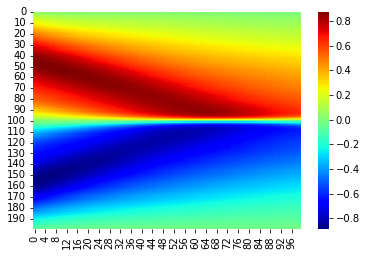

In [7]:
sns.heatmap(y_pred, cmap='jet')

In [8]:
import scipy.io

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None] #(100, 1)
x = data['x'].flatten()[:,None] #(256, 1)
Exact = np.real(data['usol']).T #(100, 256)

X, T = np.meshgrid(x,t) #(100, 256) for each

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #(25600, 2)
u_star = Exact.flatten()[:,None] #(25600, 1)



u_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u)) #use this metric to compare model performance                   

Error u: 1.770086e-01
